<a href="https://colab.research.google.com/github/asaad2k/-FaceLandmarkAI/blob/main/CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.

!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz



--2025-02-12 21:28:57--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.box.com (sussex.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2025-02-12 21:28:57--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2025-02-12 21:28:57--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.157, 2620:117:bff0:12d::
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.157|:443... connected.
HTTP request sent, awaiting resp

In [2]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'cf2a926d2165322adcd19d2e88b2eb1cd200ea5c')
confirm_checksum('examples.npz', '0fadc9226e4c0efb4479c5c1bf79491d75828ad3')
confirm_checksum('test_images.npz', 'c7b4b297c7e5c5009706f893ad1fb77a2aa73f95')



In [3]:
# Necessary imports for the code to run
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping

data = np.load('training_images.npz', allow_pickle=True)
images = data['images']
pts = data['points']

print("Training images shape:", images.shape)
print("Points shape:", pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print("Test images shape:", test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print("Example images shape:", example_images.shape)

Training images shape: (2811, 256, 256, 3)
Points shape: (2811, 44, 2)
Test images shape: (554, 256, 256, 3)
Example images shape: (6, 256, 256, 3)


Processed images shape: (2811, 256, 256, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


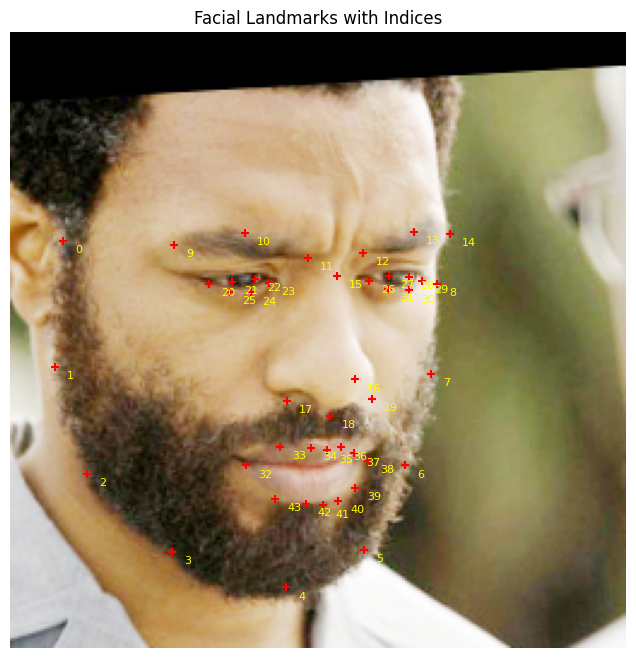

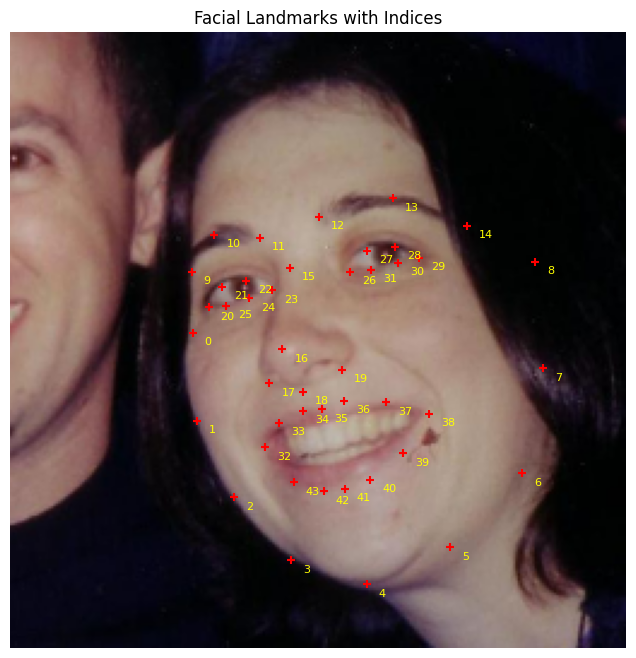

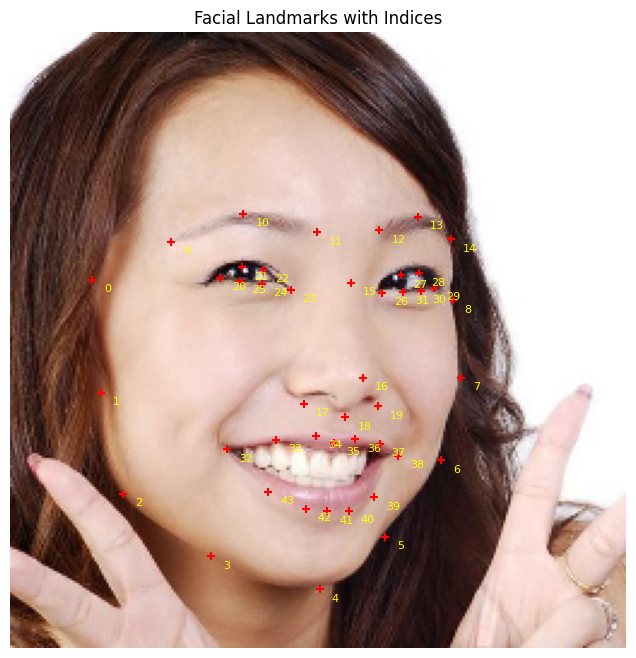

In [4]:
# Normalize image data to [0, 1] range for better neural network performance.
def preprocess_images(images):
    """
    Normalizes image data to [0, 1] range.
    This is important for neural network performance as it helps in faster convergence.
    Args:
        images (numpy.ndarray): Array of image data.
    Returns:
        numpy.ndarray: Normalized image data.
    """
    return images.astype('float32') / 255.0

processed_images = preprocess_images(images)
print("Processed images shape:", processed_images.shape)  # Confirm image shape

# Flatten images and reduce dimensionality using PCA for more manageable feature sets.
def extract_features(images, num_components=50):
    """
    Applies PCA to flatten images and reduce dimensionality for more manageable feature sets.
    Retains most variability in the data, crucial for efficient training of neural networks【2】.
    Args:
        images (numpy.ndarray): Array of processed images.
        num_components (int): Number of principal components to keep.
    Returns:
        numpy.ndarray: Transformed feature set.
    """
    n_samples, nx, ny, nz = images.shape
    flattened_images = images.reshape((n_samples, nx * ny * nz))
    pca = PCA(n_components=num_components)
    return pca.fit_transform(flattened_images)

# Define CNN model architecture
"""
    Constructs a CNN with layers suited for regression of facial landmarks.
    Uses ReLU activation and Mean Squared Error loss for training【3】.
    Args:
        input_shape (tuple): Shape of the input images.
    Returns:
        keras.models.Sequential: Compiled CNN model.
    """
def build_cnn_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Flatten(),
        Dense(500, activation='relu'),
        Dense(pts.shape[1] * 2)  # Output Layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_cnn_model(processed_images.shape[1:])

# Modify the color of specified regions based on provided landmarks.
def modify_color(image, points, new_color, region='lips'):
    """
    Modifies the color of specified facial regions based on provided landmarks【5】.
    Args:
        image (numpy.ndarray): Original image.
        points (numpy.ndarray): Array of landmark points.
        new_color (tuple): RGB color tuple.
        region (str): Target region to modify color.
    Returns:
        numpy.ndarray: Modified image.
    """
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [points[region]], new_color)
    result = image.copy()
    result[mask > 0] = new_color
    return result

# Visualize facial points on images.
def visualise_pts(image, points, show_labels=True):
    """
    Visualizes facial landmarks on an image with optional labels for each point【4】.
    Args:
        image (numpy.ndarray): Image to plot.
        points (numpy.ndarray): Landmark points.
        show_labels (bool): If True, shows labels for each landmark point.
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    for i, (x, y) in enumerate(points):
        plt.scatter(x, y, color='red', marker='+')  # Plot each point
        if show_labels:
            plt.text(x + 5, y + 5, str(i), color='yellow', fontsize=8)  # Offset text slightly from point

    plt.title('Facial Landmarks with Indices')
    plt.axis('off')
    plt.show()

# Visualize points on a few training images
for i in range(3):
    idx = np.random.randint(0, images.shape[0])
    visualise_pts(images[idx], pts[idx])

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 709s 9s/step - loss: 4654.0747 - val_loss: 541.9276
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 704s 9s/step - loss: 245.5369 - val_loss: 138.8457
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 738s 9s/step - loss: 113.0524 - val_loss: 98.7402
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 744s 9s/step - loss: 91.1906 - val_loss: 79.6202
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 747s 9s/step - loss: 78.5103 - val_loss: 71.1750
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 704s 9s/step - loss: 56.9729 - val_loss: 50.9434
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 750s 9s/step - loss: 48.9232 - val_loss: 46.9386
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 738s 9s/step - loss: 49.5633 - val_loss: 50.5247
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 746s 9s/step - loss: 40.3511 - val_loss: 53.7071
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 707s 9s/step - loss: 40.5070 - val_loss: 49.2992
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 745s 9s/step - loss: 39.2751 - val_loss: 45.2620
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━

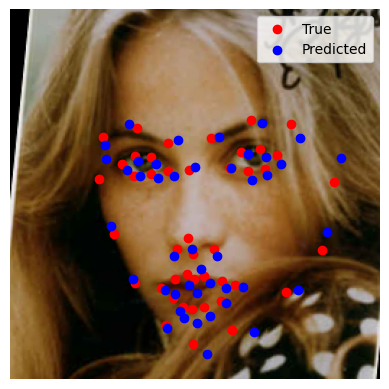

Visualizing example from index 2223
True points shape: (44, 2) Predicted points shape: (44, 2)


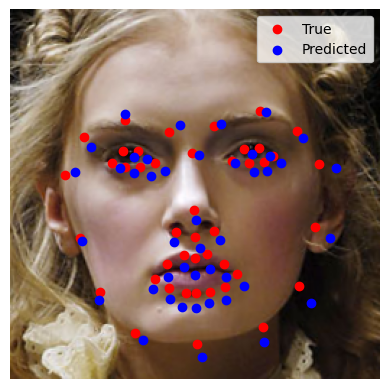

Visualizing example from index 93
True points shape: (44, 2) Predicted points shape: (44, 2)


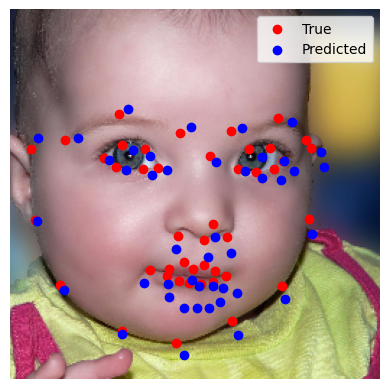

In [5]:

# Preprocess images and extract features
processed_images = preprocess_images(images)
features = extract_features(processed_images)

# Train the model, Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(processed_images, pts.reshape((pts.shape[0], pts.shape[1]*2)), epochs=50, batch_size=32,
          validation_split=0.1, callbacks=[early_stopping])

# Calculate Structured Mean Error (SME)
"""
    Calculates Structured Mean Error (SME) between predicted and actual landmarks【3】.
    Args:
        predicted_pts (numpy.ndarray): Predicted landmark points.
        actual_pts (numpy.ndarray): Actual landmark points.
        reference_pts (numpy.ndarray): Reference points for normalization.
    Returns:
        float: Calculated SME.
"""
def calculate_sme(predicted_pts, actual_pts, reference_pts):
    distances = np.sqrt(np.sum((predicted_pts - actual_pts)**2, axis=2))
    inter_ocular_distance = np.linalg.norm(reference_pts[:,0] - reference_pts[:,1], axis=1)
    sme = np.mean(distances / inter_ocular_distance[:, np.newaxis])
    return sme

# Predict landmarks
predicted_pts = model.predict(processed_images)
predicted_pts = predicted_pts.reshape((-1, pts.shape[1], pts.shape[2]))


# Calculate SME and print average error
reference_pts = pts[:, [0, 1]]  # Assuming the first two points are the eye corners
sme = calculate_sme(predicted_pts, pts, reference_pts)
print(f"Structured Mean Error: {sme:.2f}")


# Function to visualize the predictions for qualitative analysis
"""
    Visualizes the predictions for qualitative analysis, showing true and predicted landmarks【4】.
    Args:
        image (numpy.ndarray): Image to plot.
        true_points (numpy.ndarray): True landmark points.
        predicted_points (numpy.ndarray): Predicted landmark points.
"""

def visualize_predictions(image, true_points, predicted_points):
    plt.imshow(image)
    plt.scatter(true_points[:, 0], true_points[:, 1], color='red', label='True')
    plt.scatter(predicted_points[:, 0], predicted_points[:, 1], color='blue', label='Predicted')
    plt.legend()
    plt.axis('off')  # Optionally turn off the axis
    plt.show()

# Choose random indices for visualization
random_indices = np.random.choice(images.shape[0], 3, replace=False)

# Visualize predictions on randomly selected examples
for idx in random_indices:
    print(f"Visualizing example from index {idx}")
    print("True points shape:", pts[idx].shape, "Predicted points shape:", predicted_pts[idx].shape)
    visualize_predictions(images[idx], pts[idx], predicted_pts[idx])

In [8]:
# Function to save predicted points as a CSV file and download it
def save_as_csv(points, filename='Testing.csv'):
    # Update the assertion to the correct expected shape
    assert points.shape[1:] == (44, 2), 'Shape mismatch: Expected (?, 44, 2), got ' + str(points.shape)
    # Flatten the points to save in CSV format
    flat_points = points.reshape((points.shape[0], -1))
    # Save the points to a CSV file
    np.savetxt(filename, flat_points, delimiter=',', fmt='%f')

# Use the function to save your predictions
save_as_csv(predicted_pts)